### Test LinUCB, ThresholdBandit and GreedyBandit

In [1]:
%cd /home/lansdell/projects/conservativerdd
%pylab inline
pylab.rcParams['figure.figsize'] = (6, 6)

from lib.bandits import LinUCB, ThresholdBandit,ThresholdConsBandit,GreedyBandit, ConsLinUCB, expected_regret, expected_regret_per_arm
from lib.generator import LinearGeneratorParams, LinearGenerator
import numpy as np 

import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import seaborn as sns
sns.set_style('ticks')

/home/lansdell/projects/conservativerdd
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/lansdell/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
#alg = 'greedy'
#alg = 'linucb'
#alg = 'threshold'
#alg = 'thresholdcons'
alg = 'conslinucb'

M = 3    #number of runs
N = 10000 #number of timesteps
save = False
alpha = 0.1 #CLUCB parameter...
max_alpha = 2
max_beta = 2
k = 4    #Number of arms
d = 5   #Dimension of context (includes one dim for intercept term)
intercept = True
evaluate_every = 100

if alg == 'greedy':
	BanditAlg = GreedyBandit
elif alg == 'linucb':
	BanditAlg = LinUCB
elif alg == 'threshold':
	BanditAlg = ThresholdBandit
elif alg == 'thresholdcons':
	BanditAlg = ThresholdConsBandit
elif alg == 'conslinucb':
	BanditAlg = ConsLinUCB
else:
	print("Select a valid algorithm")

## Run CLUCB 

In [4]:
#Generate slopes and intercepts
alphas = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,k,d-1))
betas = truncnorm.rvs(-max_beta, max_beta, scale = 1, size=(M,k))

#baseline_alphas = truncnorm.rvs(-max_alpha, max_alpha, scale = 1, size=(M,1,d-1))
#baseline_betas = truncnorm.rvs(-max_beta, max_beta, scale = 1, size=(M,1))

regret = np.zeros((M, N))
expt_regret = np.zeros((M, N))
arm_pulls = np.zeros((M, N, k+1))
n_changes = np.zeros((M, N))
update_pol = np.zeros((M, N))

In [5]:
print("Running %s algorithm"%alg)
expt_rewards_clucb = np.zeros((M, N))
expt_rewards_baseline_clucb = np.zeros((M, N))

for m in range(M):
    params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
    generator = LinearGenerator(params)
    means = expected_regret_per_arm(generator)
    #Choose the baseline arm as the worst arm....
    m_idx = np.argmin(means)
    base_alpha = alphas[m,m_idx,:]
    base_beta = betas[m,m_idx]
    #bandit = BanditAlg(generator, (np.squeeze(baseline_alphas[m,:]), baseline_betas[m,0]), alpha = 0.1)
    bandit = BanditAlg(generator, (base_alpha, base_beta), alpha = alpha)
    print("Run: %d/%d"%(m+1,M))
    for i in range(N):
        (ctx, arm_idx, obs, r) = bandit.step()
        regret[m,i] = r
        if arm_idx >= 0:
            arm_pulls[m,i,arm_idx] = 1
        else:
            arm_pulls[m,i,k] = 1
    expt_rewards_baseline[m,i] = np.dot(ctx[1:],base_alpha) + base_beta
    expt_rewards[m,i] = np.dot(ctx[1:], alphas[m,arm_idx,:]) + betas[m,arm_idx]


Running conslinucb algorithm
Run: 1/3
Run: 2/3
Run: 3/3


## LinUCB for comparison

In [6]:
BanditAlg = LinUCB    
regret_linucb = np.zeros((M, N))
arm_pulls_linucb = np.zeros((M, N, k+1))

In [7]:
for m in range(M):
	params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
	generator = LinearGenerator(params)
	bandit = BanditAlg(generator)
	print("Run: %d/%d"%(m+1,M))
	for i in range(N):
		(ctx, arm_idx, obs, r) = bandit.step()
		regret_linucb[m,i] = r
		if arm_idx >= 0:
			arm_pulls_linucb[m,i,arm_idx] = 1
		else:
			arm_pulls_linucb[m,i,k] = 1

Run: 1/3
Run: 2/3
Run: 3/3


## Threshold cons for comparison

In [8]:
BanditAlg = ThresholdConsBandit    
regret_thrcons = np.zeros((M, N))
arm_pulls_thrcons = np.zeros((M, N, k+1))

In [9]:
for m in range(M):
	params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
	generator = LinearGenerator(params)
	bandit = BanditAlg(generator)
	print("Run: %d/%d"%(m+1,M))
	for i in range(N):
		(ctx, arm_idx, obs, r) = bandit.step()
		regret_thrcons[m,i] = r
		if arm_idx >= 0:
			arm_pulls_linucb[m,i,arm_idx] = 1
		else:
			arm_pulls_linucb[m,i,k] = 1

Run: 1/3
Run: 2/3
Run: 3/3


## Threshold greedy

In [10]:
BanditAlg = ThresholdBandit    
regret_thrgre = np.zeros((M, N))
arm_pulls_thrgre = np.zeros((M, N, k+1))

In [11]:
for m in range(M):
	params = LinearGeneratorParams(np.atleast_2d(alphas[m,:,:]), betas[m,:], d = d, k = k, intercept = intercept)
	generator = LinearGenerator(params)
	bandit = BanditAlg(generator)
	print("Run: %d/%d"%(m+1,M))
	for i in range(N):
		(ctx, arm_idx, obs, r) = bandit.step()
		regret_thrgre[m,i] = r
		if arm_idx >= 0:
			arm_pulls_linucb[m,i,arm_idx] = 1
		else:
			arm_pulls_linucb[m,i,k] = 1

Run: 1/3
Run: 2/3
Run: 3/3


## Comparison of the methods

Trade-off between convergence rate, risk, and confidence level

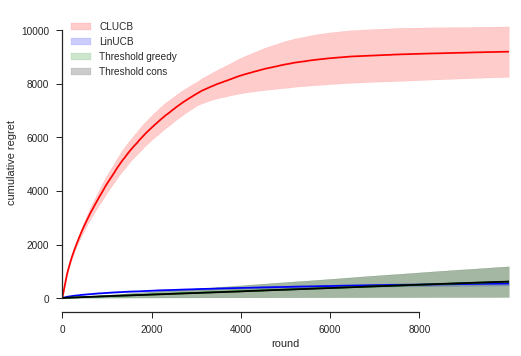

In [13]:
#Vary the confidence level, plot convergence rate, regret, risk
sns.tsplot(np.cumsum(regret, axis = 1), color = 'red')
sns.tsplot(np.cumsum(regret_linucb, axis = 1), color = 'blue')
sns.tsplot(np.cumsum(regret_thrgre, axis = 1), color = 'green')
sns.tsplot(np.cumsum(regret_thrcons, axis = 1), color = 'black')
plt.xlabel('round')
plt.ylabel('cumulative regret')
plt.legend(['CLUCB', 'LinUCB', 'Threshold greedy', 'Threshold cons'])
sns.despine(trim = True)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


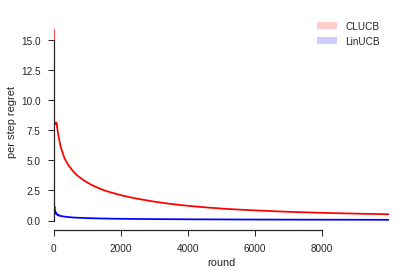

In [8]:
#Vary the confidence level, plot convergence rate, regret, risk
sns.tsplot(np.divide(np.cumsum(regret, axis = 1), np.arange(N)), color = 'red')
sns.tsplot(np.divide(np.cumsum(regret_linucb, axis = 1),np.arange(N)), color = 'blue')
plt.xlabel('round')
plt.ylabel('per step regret')
plt.legend(['CLUCB', 'LinUCB'])
sns.despine(trim = True)

## Plot the violation of constraints........

In [ ]:
#cum_expt_rewards_rs = np.cumsum(expt_rewards_rs, axis = 1)
#cum_expt_rewards_baseline_rs = np.cumsum(expt_rewards_baseline_rs, axis = 1)
cum_expt_rewards_ucb = np.cumsum(expt_rewards_ucb, axis = 1)
cum_expt_rewards_baseline_ucb = np.cumsum(expt_rewards_baseline_ucb, axis = 1)
cum_expt_rewards_thr = np.cumsum(expt_rewards_thr, axis = 1)
cum_expt_rewards_baseline_thr = np.cumsum(expt_rewards_baseline_thr, axis = 1)
cum_expt_rewards_thrcons = np.cumsum(expt_rewards_thrcons, axis = 1)
cum_expt_rewards_baseline_thrcons = np.cumsum(expt_rewards_baseline_thrcons, axis = 1)
#cum_expt_rewards_gre = np.cumsum(expt_rewards_gre, axis = 1)
#cum_expt_rewards_baseline_gre = np.cumsum(expt_rewards_baseline_gre, axis = 1)
cum_expt_rewards_clucb = np.cumsum(expt_rewards_clucb, axis = 1)
cum_expt_rewards_baseline_clucb = np.cumsum(expt_rewards_baseline_clucb, axis = 1)

constraint_violation_clucb = np.mean((cum_expt_rewards_clucb.T - (1-alpha_clucb)*cum_expt_rewards_baseline_clucb.T)<0,0)
#constraint_violation_gre = np.mean((cum_expt_rewards_gre.T - (1-alpha_clucb)*cum_expt_rewards_baseline_gre.T)<0,0)
#constraint_violation_ucb = np.mean((cum_expt_rewards_ucb.T - (1-alpha_clucb)*cum_expt_rewards_baseline_ucb.T)<0,0)
#constraint_violation_rs = np.mean((cum_expt_rewards_rs.T - (1-alpha_clucb)*cum_expt_rewards_baseline_rs.T)<0,0)
constraint_violation_thr = np.mean((cum_expt_rewards_thr.T - (1-alpha_clucb)*cum_expt_rewards_baseline_thr.T)<0,0)
constraint_violation_thrcons = np.mean((cum_expt_rewards_thrcons.T - (1-alpha_clucb)*cum_expt_rewards_baseline_thrcons.T)<0,0)

all_method_constraints = 100*np.stack((constraint_violation_ucb,
                                       constraint_violation_thr,
                                       constraint_violation_thrcons,
                                       constraint_violation_clucb))

#all_method_constraints = 100*np.stack((constraint_violation_ucb,
#                                       constraint_violation_gre,
#                                       constraint_violation_thr,
#                                       constraint_violation_thrcons,
#                                       constraint_violation_rs,
#                                       constraint_violation_clucb))

#df_constraints = pd.DataFrame(data = all_method_constraints.T, columns = ['LinUCB', 'Greedy', 'RS-greedy', 'RS-conservative', 'RS-LinUCB', 'CLUCB'], index = range(M))
df_constraints = pd.DataFrame(data = all_method_constraints.T, columns = ['LinUCB', 'RS-greedy', 'RS-conservative', 'CLUCB'], index = range(M))